# Data Analysis

In [1]:
# See https://github.com/ultralytics/ultralytics/issues/1270 
!pip install opencv-python-headless pandas matplotlib distinctipy cjm_pytorch_utils

In [2]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import json
from PIL import Image, ImageFont
from functools import partial
from distinctipy import distinctipy

import torch
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
from torchvision.ops import box_convert
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
from cjm_pytorch_utils.core import tensor_to_pil

## Data analysis original data
The description can be found [here](https://dentex.grand-challenge.org/data/).

In [3]:
path_qd = "./dentex_dataset/origin/quadrant_enumeration_disease"
os.listdir(path_qd)

['xrays', 'train_quadrant_enumeration_disease.json', '.ipynb_checkpoints']

In [4]:
with open("./dentex_dataset/origin/quadrant_enumeration_disease/train_quadrant_enumeration_disease.json", "r") as json_file:
    json_content = json.load(json_file)
    images = pd.DataFrame(json_content["images"]).set_index("id")
    annotations = pd.DataFrame(json_content["annotations"]).set_index("id")
    quadrant = pd.DataFrame(json_content["categories_1"]).set_index("id")
    tooth_number = pd.DataFrame(json_content["categories_2"]).set_index("id")
    disease = pd.DataFrame(json_content["categories_3"]).set_index("id")

In [5]:
images

,height,width,file_name
id,,,
1,1316,2744,train_673.png
2,1504,2872,train_283.png
3,1316,2909,train_435.png
4,1504,2872,train_95.png
5,1504,2872,train_475.png
...,...,...,...
701,1316,2910,train_338.png
702,1316,2851,train_657.png
703,1316,2850,train_344.png


In [6]:
annotations

,iscrowd,image_id,bbox,segmentation,area,category_id_1,category_id_2,category_id_3
id,,,,,,,,
1,0,1,"[542.0, 698.0, 220.0, 271.0]","[[621, 703, 573, 744, 542, 885, 580, 945, 650,...",39683,3,7,0
2,0,1,"[1952.0, 693.0, 177.0, 270.0]","[[2045, 693, 2109, 734, 2129, 915, 2047, 963, ...",33301,2,7,0
3,0,1,"[675.0, 708.0, 243.0, 300.0]","[[784, 711, 754, 746, 737, 821, 678, 916, 675,...",45758,3,6,1
4,0,1,"[1463.0, 725.0, 98.0, 425.0]","[[1464, 749, 1513, 725, 1550, 760, 1555, 798, ...",30985,2,2,1
5,0,1,"[1536.0, 753.0, 103.0, 381.0]","[[1543, 796, 1590, 753, 1622, 796, 1629, 840, ...",28044,2,3,1
...,...,...,...,...,...,...,...,...
3525,0,705,"[1851.2857142857142, 474.2857142857142, 117.14...","[[1885, 477, 1868, 597, 1859, 657, 1851, 728, ...",28938,1,5,1
3526,0,705,"[1959.0, 479.9999999999999, 127.0, 274.2857142...","[[2005, 488, 1974, 479, 1965, 522, 1965, 588, ...",23181,1,6,1
3527,0,705,"[2024.9999999999998, 463.0, 147.00000000000023...","[[2064, 463, 2024, 471, 2036, 559, 2056, 628, ...",20023,1,7,3


In [7]:
# Check for missing values
missing_values = annotations.isna().sum()
print(missing_values)

iscrowd          0
image_id         0
bbox             0
segmentation     0
area             0
category_id_1    0
category_id_2    0
category_id_3    0
dtype: int64


In [8]:
quadrant

,name,supercategory
id,,
0,1,1
1,2,2
2,3,3
3,4,4


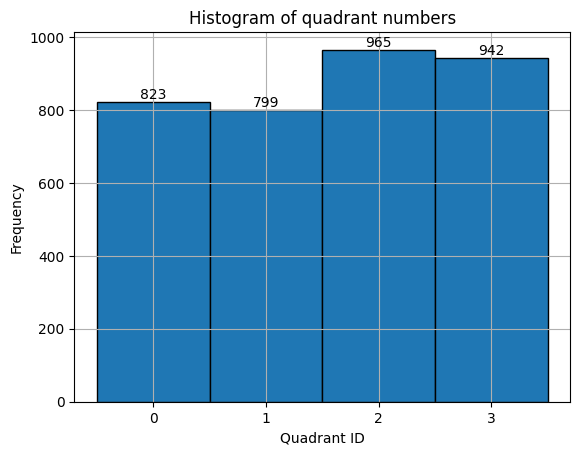

In [9]:
# Filter out non-integer values and drop NaNs
whole_numbers = annotations['category_id_1'].astype(int)

# Determine the range for the histogram
data_min = whole_numbers.min() 
data_max = whole_numbers.max()

# Plot histogram
plt.hist(whole_numbers, bins=np.arange(data_min-0.5, data_max+1.5), edgecolor='black') 

# Display counts on top of each bar
counts = whole_numbers.value_counts() 
for i in range(data_min, data_max + 1): 
    plt.text(i, counts.get(i, 0), str(counts.get(i, 0)), ha='center', va='bottom')

plt.title('Histogram of quadrant numbers') 
plt.xlabel('Quadrant ID') 
plt.ylabel('Frequency') 
plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [10]:
tooth_number

,name,supercategory
id,,
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
5,6,6
6,7,7
7,8,8


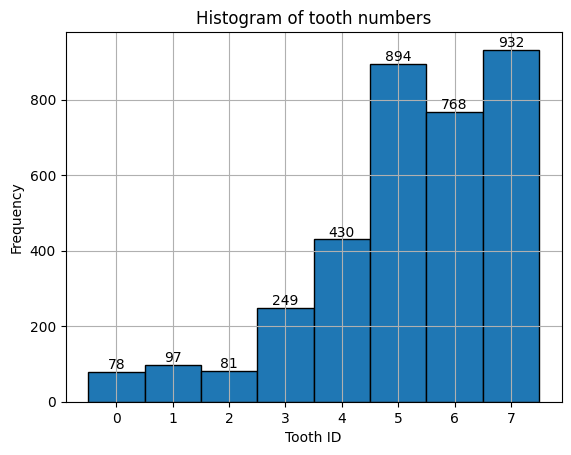

In [11]:
# Filter out non-integer values and drop NaNs
whole_numbers = annotations['category_id_2'].astype(int)

# Determine the range for the histogram
data_min = whole_numbers.min() 
data_max = whole_numbers.max()

# Plot histogram
plt.hist(whole_numbers, bins=np.arange(data_min-0.5, data_max+1.5), edgecolor='black') 

# Display counts on top of each bar
counts = whole_numbers.value_counts() 
for i in range(data_min, data_max + 1): 
    plt.text(i, counts.get(i, 0), str(counts.get(i, 0)), ha='center', va='bottom')

plt.title('Histogram of tooth numbers') 
plt.xlabel('Tooth ID') 
plt.ylabel('Frequency') 
plt.grid(True) 
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [12]:
disease

,name,supercategory
id,,
0,Impacted,Impacted
1,Caries,Caries
2,Periapical Lesion,Periapical Lesion
3,Deep Caries,Deep Caries


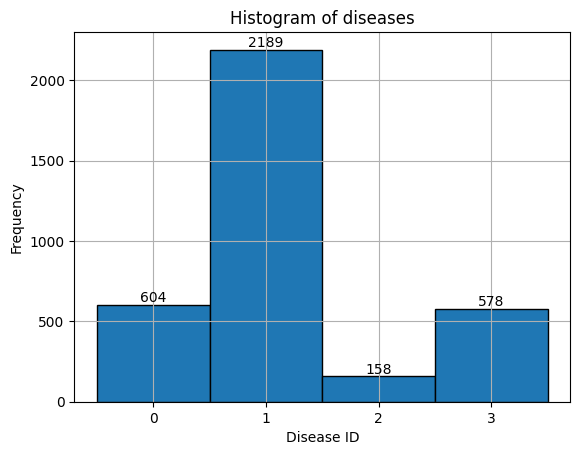

In [13]:
# Filter out non-integer values and drop NaNs
whole_numbers = annotations['category_id_3'].astype(int)

# Determine the range for the histogram
data_min = whole_numbers.min() 
data_max = whole_numbers.max()

# Plot histogram
plt.hist(whole_numbers, bins=np.arange(data_min-0.5, data_max+1.5), edgecolor='black') 

# Display counts on top of each bar
counts = whole_numbers.value_counts() 
for i in range(data_min, data_max + 1): 
    plt.text(i, counts.get(i, 0), str(counts.get(i, 0)), ha='center', va='bottom')

plt.title('Histogram of diseases') 
plt.xlabel('Disease ID') 
plt.ylabel('Frequency') 
plt.grid(True) 

# Use MaxNLocator to ensure only whole numbers are used on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

### Facit
The dataset was created by 3 expert dentists and is of very high quality. It contains no null values. <br>
While diseases occur in all quadrants similarily there is a pattern that the teeth more close to the edges are more often affected by diseases. <br>
Of the classified diseases, caries occur most by far. It occurs ~14x more than the least occuring class (Periapical Lesion)

## First Example

Look into the first example in detail

In [14]:
images[:1]

,height,width,file_name
id,,,
1,1316,2744,train_673.png


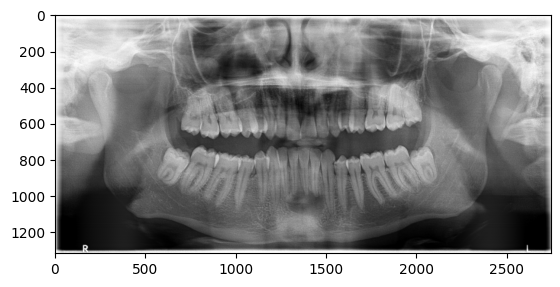

In [15]:
image_path = './dentex_dataset/origin/quadrant_enumeration_disease/xrays/train_673.png'
image = cv2.imread(image_path)
plt.imshow(image)

In [16]:
annotation = annotations[:1]
annotation

,iscrowd,image_id,bbox,segmentation,area,category_id_1,category_id_2,category_id_3
id,,,,,,,,
1,0,1,"[542.0, 698.0, 220.0, 271.0]","[[621, 703, 573, 744, 542, 885, 580, 945, 650,...",39683,3,7,0


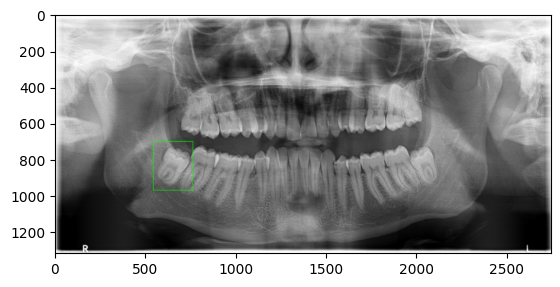

In [17]:
image_path = './dentex_dataset/origin/quadrant_enumeration_disease/xrays/train_673.png'
image = cv2.imread(image_path)

# Unpack bounding box coordinates
bbox = annotations["bbox"][1]

# Extract coordinates
x_min = int(bbox[0])
y_min = int(bbox[1])
width = int(bbox[2])
height = int(bbox[3])

# Convert to OpenCV bounding box format
cv2_bbox = (x_min, y_min, width, height)
# Draw bounding box
cv2.rectangle(image, cv2_bbox, (0, 255, 0), 2)  # Green rectangle with thickness 2

plt.imshow(image)

This tooth, quadrant: 4, number: 8 is impacted 

In [18]:
segmentation_mask = annotations["segmentation"][1]
segmentation_mask

[[621,
  703,
  573,
  744,
  542,
  885,
  580,
  945,
  650,
  969,
  711,
  883,
  762,
  807,
  748,
  741,
  649,
  698]]

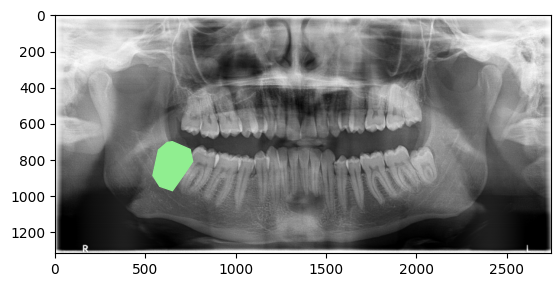

In [19]:
image_path = './dentex_dataset/origin/quadrant_enumeration_disease/xrays/train_673.png'
image = cv2.imread(image_path)

# Coordinates of the polygon
polygon_coords = annotations["segmentation"][1]

# Reshape the polygon coordinates into pairs of (x, y) points
points = np.array(polygon_coords).reshape(-1, 2)

# Fill the polygon with white color (255)
plt.fill(points[:, 0], points[:, 1], color='lightgreen')

# Display the segmentation overlaying on a blank image
plt.imshow(image)

## Preprocess Boundingbox Detection
### Group and merge

In [20]:
data_dir = './dentex_dataset/origin/training_data/quadrant-enumeration-disease/xrays'
annotation_file = "./dentex_dataset/origin/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json"

with open(annotation_file, "r") as json_file:
    json_content = json.load(json_file)
    annotations = pd.DataFrame(json_content["annotations"]).set_index("id")
    images = pd.DataFrame(json_content["images"]).set_index("id")

# group py image id, rename and drop some cols
annotations = annotations \
    .drop(columns=['iscrowd', 'segmentation', 'area']) \
    .rename(columns={'category_id_1': 'quadrant', 'category_id_2': 'tooth_number','category_id_3': 'disease'}) \
    .groupby('image_id').agg(lambda x: x.tolist())

# convert to integer
annotations['bbox'] = annotations['bbox'].apply(lambda x: [np.array(sublist).astype(int) for sublist in x])

# merge with image metadata
target_df = pd.merge(annotations, images, left_on='image_id', right_on='id', how='left')
target_df

,bbox,quadrant,tooth_number,disease,height,width,file_name
0,"[[542, 698, 220, 271], [1952, 693, 177, 270], ...","[3, 2, 3, 2, 2, 2, 1, 0, 2, 2, 2, 2, 3]","[7, 7, 6, 2, 3, 4, 5, 6, 5, 6, 1, 0, 0]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]",1316,2744,train_673.png
1,"[[792, 980, 168, 165], [2013, 1049, 140, 135],...","[3, 2, 2, 1]","[7, 7, 6, 5]","[0, 0, 1, 1]",1504,2872,train_283.png
2,"[[843, 838, 190, 325], [1006, 826, 177, 345], ...","[3, 3, 3, 3, 2, 2, 0, 0, 1, 1, 1, 2, 1, 1]","[6, 5, 4, 3, 3, 6, 7, 6, 1, 4, 5, 4, 7, 6]","[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1]",1504,2872,train_95.png
3,"[[1082, 863, 109, 301], [1211, 891, 200, 298]]","[3, 3]","[3, 1]","[3, 2]",1504,2872,train_475.png
4,"[[1061, 504, 103, 298], [761, 464, 159, 240], ...","[0, 0, 1, 3, 3, 1]","[4, 7, 7, 4, 5, 4]","[1, 3, 1, 3, 3, 3]",1316,2867,train_62.png
...,...,...,...,...,...,...,...
673,"[[1795, 437, 208, 304], [1084, 781, 153, 268],...","[1, 3, 3, 3, 2]","[5, 4, 6, 7, 7]","[1, 1, 1, 0, 0]",1316,2910,train_338.png
674,"[[1916, 471, 127, 300], [1677, 795, 116, 279]]","[1, 2]","[6, 4]","[1, 1]",1316,2851,train_657.png
675,"[[1042, 418, 96, 293], [933, 423, 129, 284], [...","[0, 0, 1]","[4, 5, 6]","[3, 1, 1]",1316,2850,train_344.png
676,"[[2185, 855, 186, 310], [658, 454, 157, 356], ...","[2, 0, 3, 1, 2, 0, 1]","[7, 7, 6, 6, 4, 4, 3]","[0, 1, 1, 1, 1, 2, 2]",1504,2872,train_599.png


### One hot encoding
Is used as some model only deliver one label

In [21]:
def merge_categories(quadrant, tooth_number, disease):
    """
    Merge three categorical variables into a single tensor using one-hot encoding.
    
    Args:
    - quadrant (int): The quadrant category (1 to 4).
    - tooth_number (int): The tooth number category (1 to 8).
    - disease (int): The disease category (1 to 4).
    
    Returns:
    - merged_tensor (torch.Tensor): The merged tensor representing the categories.
    """
    num_quadrants = 4
    num_tooth_numbers = 8
    num_diseases = 4

    # Create one-hot encodings for each category
    quadrant_one_hot = torch.zeros(num_quadrants)
    quadrant_one_hot[quadrant] = 1 
    tooth_number_one_hot = torch.zeros(num_tooth_numbers)
    tooth_number_one_hot[tooth_number] = 1
    disease_one_hot = torch.zeros(num_diseases)
    disease_one_hot[disease] = 1

    # Concatenate the one-hot encodings to form a single tensor
    merged_tensor = torch.cat((quadrant_one_hot, tooth_number_one_hot, disease_one_hot), dim=0)
    
    return merged_tensor

def unmerge_categories(merged_tensor):
    """
    Unmerge the merged tensor back into the original three categorical variables.
    
    Args:
    - merged_tensor (torch.Tensor): The merged tensor representing the categories.
    
    Returns:
    - quadrant (int): The quadrant category (1 to 4).
    - tooth_number (int): The tooth number category (1 to 8).
    - disease (int): The disease category (1 to 4).
    """
    num_quadrants = 4
    num_tooth_numbers = 8
    num_diseases = 4
    
    # Split the merged tensor into three parts
    quadrant_one_hot = merged_tensor[:num_quadrants]
    tooth_number_one_hot = merged_tensor[num_quadrants:num_quadrants+num_tooth_numbers]
    disease_one_hot = merged_tensor[-num_diseases:]

    # Find the index of the active element (1) in each one-hot encoding
    quadrant = torch.argmax(quadrant_one_hot)  
    tooth_number = torch.argmax(tooth_number_one_hot)
    disease = torch.argmax(disease_one_hot)

    return quadrant.item(), tooth_number.item(), disease.item()

In [22]:
disease_dict = {
    0: "Impacted",
    1: "Caries",
    2: "Periapical Lesion",
    3: "Deep Caries"
}

In [23]:
# Example usage:
# Max values
quadrant = 3
tooth_number = 7
disease = 3

merged_tensor = merge_categories(quadrant, tooth_number, disease)
print("Merged tensor:", merged_tensor)

unmerged_quadrant, unmerged_tooth_number, unmerged_disease = unmerge_categories(merged_tensor)
print("Unmerged categories: ", "\n\tquadrant: ", unmerged_quadrant + 1, "\n\ttooth No: ",unmerged_tooth_number + 1, "\n\tdisease: ",disease_dict[unmerged_disease])
# Min values
quadrant = 0
tooth_number = 0
disease = 0

merged_tensor = merge_categories(quadrant, tooth_number, disease)
print("Merged tensor:", merged_tensor)

unmerged_quadrant, unmerged_tooth_number, unmerged_disease = unmerge_categories(merged_tensor)
print("Unmerged categories: ", "\n\tquadrant: ", unmerged_quadrant + 1, "\n\ttooth No: ",unmerged_tooth_number + 1, "\n\tdisease: ",disease_dict[unmerged_disease])

# apply that for every row in the dataframe
image_df = target_df.head(5)
labels = [[merge_categories(q, t, d) for q, t, d in zip(row['quadrant'], row['tooth_number'], row['disease'])] for _, row in image_df.iterrows()]
labels

Merged tensor: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
Unmerged categories:  
	quadrant:  4 
	tooth No:  8 
	disease:  Deep Caries
Merged tensor: tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Unmerged categories:  
	quadrant:  1 
	tooth No:  1 
	disease:  Impacted


[[tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]),
  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]),
  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
  tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
  tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]),
  tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]),
  tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]),
  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]),
  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])],
 [tensor([0

### Display boundingboxes and diseases

In [24]:
image_df = target_df.head(1)
image_df

,bbox,quadrant,tooth_number,disease,height,width,file_name
0,"[[542, 698, 220, 271], [1952, 693, 177, 270], ...","[3, 2, 3, 2, 2, 2, 1, 0, 2, 2, 2, 2, 3]","[7, 7, 6, 2, 3, 4, 5, 6, 5, 6, 1, 0, 0]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]",1316,2744,train_673.png


In [25]:
def convert_bbox(bbox):
    return box_convert(torch.Tensor(bbox), 'xywh', 'xyxy')

def reverse_convert_bbox(bbox):
    return box_convert(torch.Tensor(bbox), 'xyxy', 'xywh')

/tmp/ipykernel_5108/3281385609.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/torch/csrc/utils/tensor_new.cpp:261.)
  return box_convert(torch.Tensor(bbox), 'xywh', 'xyxy')


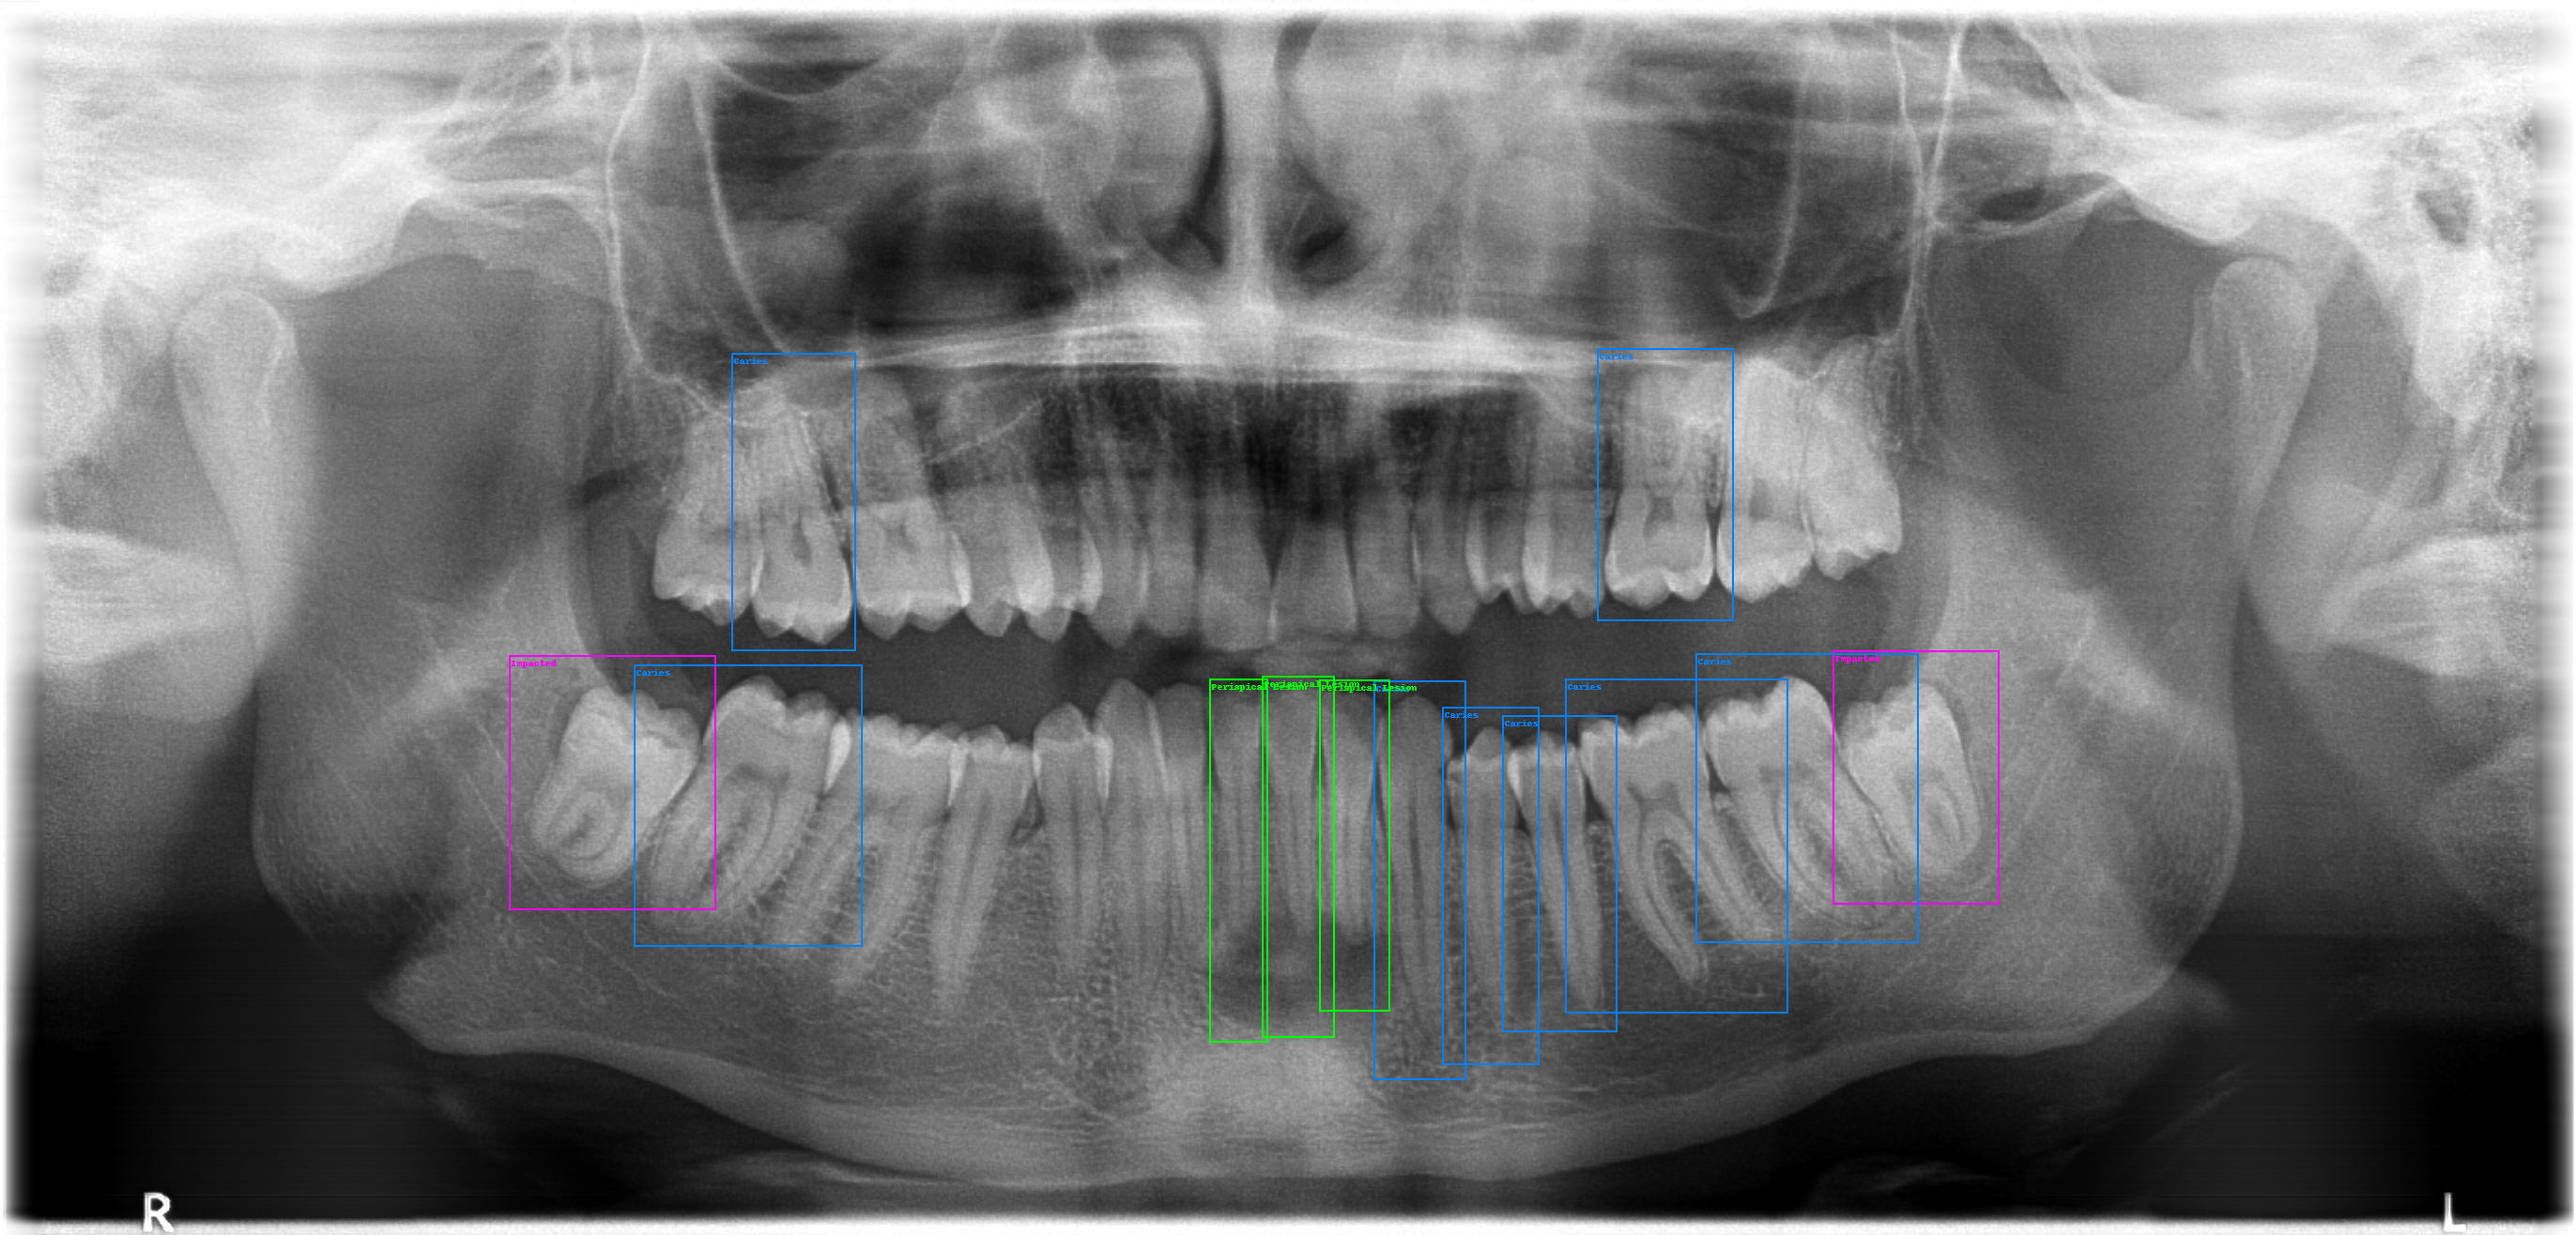

In [26]:
# Get the file ID of the first image file
file_path = os.path.join(data_dir, image_df['file_name'][0])

# Open the associated image file as a RGB image
sample_img = Image.open(file_path).convert('L')

# Extract the labels and bounding box annotations for the sample image
labels = [disease_dict[label] for label in image_df.loc[0]['disease']]
class_names = list(set(labels))
bboxes = np.array(convert_bbox(image_df.loc[0]['bbox']), dtype=np.float32).reshape(len(labels), 4)

# Annotate the sample image with labels and bounding boxes
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2)
colors = distinctipy.get_colors(4)
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=BoundingBoxes(bboxes, format='xyxy', canvas_size=sample_img.size[::-1]),
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

### Resize boundingbox

In [27]:
def resize_bbox_xywh(bbox, old_size, new_size):
    x_scale = new_size[0] / old_size[0]
    y_scale = new_size[1] / old_size[1]
    
    return [bbox[0] * x_scale, bbox[1] * y_scale, bbox[2] * x_scale, bbox[3] * y_scale]

In [28]:
file_path = os.path.join(data_dir, target_df['file_name'][0])
sample_img = Image.open(file_path).convert('L')

bbox = target_df['bbox'].values[0][0]
width = target_df['width'].values[0]
height = target_df['height'].values[0]

old_size = (width, height)
new_size = (512, 512)

transform = transforms.Compose([
    transforms.Resize(new_size),
    transforms.ToTensor(),  # Convert PIL Image to Tensor
])


new_bbox = resize_bbox_xywh(bbox, old_size, new_size) #resize_bbox()
new_bbox

[101.13119533527697, 271.5623100303951, 41.04956268221574, 105.43465045592706]

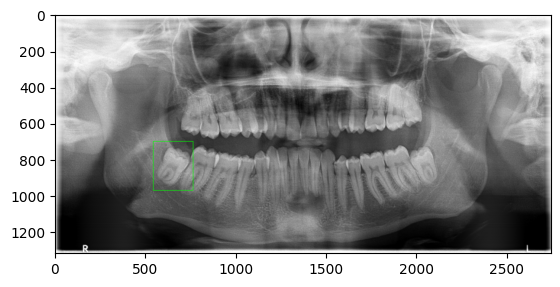

In [29]:
transformed_img = transform(sample_img)
pil_img = F.to_pil_image(transformed_img)
cv2_bbox = (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
cv2.rectangle(image, (cv2_bbox[0], cv2_bbox[1]), (cv2_bbox[0] + cv2_bbox[2], cv2_bbox[1] + cv2_bbox[3]), (0, 255, 0), 2)  # Green rectangle with thickness 2
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### COCO Dataset
COCO is a broadly supported format to train AI models

In [30]:
with open("./dentex_dataset/coco/disease_all/annotations/instances_train2017.json", "r") as json_file:
    json_content = json.load(json_file)
    images = pd.DataFrame(json_content["images"]).set_index("id")
    annotations = pd.DataFrame(json_content["annotations"]).set_index("id")
    categories = pd.DataFrame(json_content["categories"]).set_index("id")

In [31]:
images

,height,width,file_name
id,,,
1,1316,2744,train_673.png
2,1504,2872,train_283.png
3,1316,2909,train_435.png
4,1504,2872,train_95.png
5,1504,2872,train_475.png
...,...,...,...
701,1316,2910,train_338.png
702,1316,2851,train_657.png
703,1316,2850,train_344.png


In [32]:
annotations

,iscrowd,image_id,bbox,segmentation,area,category_id
id,,,,,,
1,0,1,"[542.0, 698.0, 220.0, 271.0]","[[621, 703, 573, 744, 542, 885, 580, 945, 650,...",39683,0
2,0,1,"[1952.0, 693.0, 177.0, 270.0]","[[2045, 693, 2109, 734, 2129, 915, 2047, 963, ...",33301,0
3,0,1,"[675.0, 708.0, 243.0, 300.0]","[[784, 711, 754, 746, 737, 821, 678, 916, 675,...",45758,1
4,0,1,"[1463.0, 725.0, 98.0, 425.0]","[[1464, 749, 1513, 725, 1550, 760, 1555, 798, ...",30985,1
5,0,1,"[1536.0, 753.0, 103.0, 381.0]","[[1543, 796, 1590, 753, 1622, 796, 1629, 840, ...",28044,1
...,...,...,...,...,...,...
3525,0,705,"[1851.2857142857142, 474.2857142857142, 117.14...","[[1885, 477, 1868, 597, 1859, 657, 1851, 728, ...",28938,1
3526,0,705,"[1959.0, 479.9999999999999, 127.0, 274.2857142...","[[2005, 488, 1974, 479, 1965, 522, 1965, 588, ...",23181,1
3527,0,705,"[2024.9999999999998, 463.0, 147.00000000000023...","[[2064, 463, 2024, 471, 2036, 559, 2056, 628, ...",20023,3


In [33]:
categories

,name,supercategory
id,,
0,Impacted,Impacted
1,Caries,Caries
2,Periapical Lesion,Periapical Lesion
3,Deep Caries,Deep Caries


__Facit:__ The COCO dataset looks similar to the original, the only information which is missing is tooth and quarant number

## Segmentation Enumeration32

In [34]:
with open("./dentex_dataset/origin/quadrant_enumeration_disease/train_quadrant_enumeration_disease.json", "r") as json_file:
    json_content = json.load(json_file)
    images = pd.DataFrame(json_content['images']).set_index("id")

In [35]:
images

,height,width,file_name
id,,,
1,1316,2744,train_673.png
2,1504,2872,train_283.png
3,1316,2909,train_435.png
4,1504,2872,train_95.png
5,1504,2872,train_475.png
...,...,...,...
701,1316,2910,train_338.png
702,1316,2851,train_657.png
703,1316,2850,train_344.png


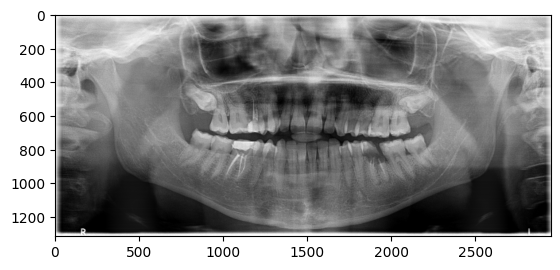

In [36]:
image_path = './dentex_dataset/segmentation/enumeration32/xrays/train_3.png'
image = cv2.imread(image_path)
plt.imshow(image)

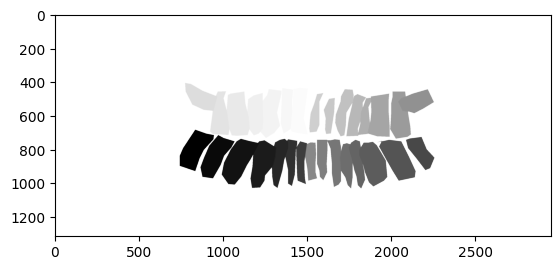

In [37]:
mask_path = './dentex_dataset/segmentation/enumeration32/masks/train_3.png'
mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask_gray, cmap='Greys')

There is one mask file based on the training file containing all teeth colored by their quadrant

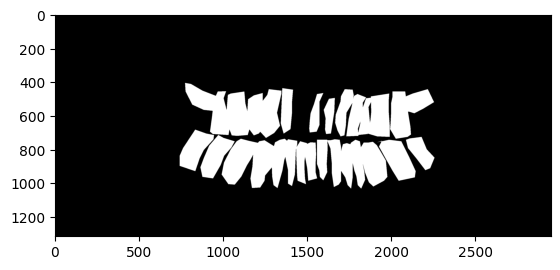

In [38]:
# threshold is set to 1 that all grey masked pixels become 1
mask_bw = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)[1]
plt.imshow(mask_bw, cmap='gray')

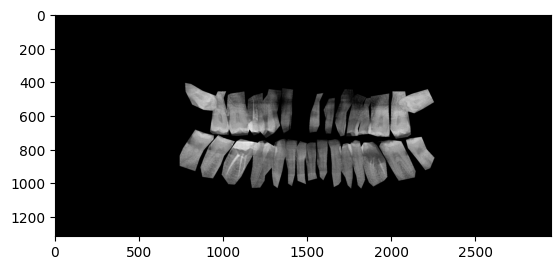

In [39]:
segmented_image = cv2.bitwise_and(image, image, mask=mask_bw)
plt.imshow(segmented_image)

## Preprocessing Segmentation dataset

In [40]:
!ls "./dentex_dataset/segmentation/enumeration32"

image_names.json  masks  segmented_images  xrays


In [41]:
def process_images(base_path):
    mask_dir = os.path.join(base_path, "masks")
    image_dir = os.path.join(base_path, "xrays")
    output_dir = os.path.join(base_path, "segmented_images")
    os.makedirs(output_dir, exist_ok=True)
    print("Start processing...")
    for mask_name in os.listdir(mask_dir):
        print(mask_name)
        mask_path = os.path.join(mask_dir, mask_name)
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_bw = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)[1]

        image_path = os.path.join(image_dir, mask_name)
        image = cv2.imread(image_path)
        segmented_image = cv2.bitwise_and(image, image, mask=mask_bw)

        output_path = os.path.join(output_dir, mask_name)
        if segmented_image is not None and len(segmented_image) > 0:
            cv2.imwrite(output_path, segmented_image)
        else:
            print(f"ERROR image {mask_name} is empty")
    print("FINISHED processing")

In [42]:
base_path = "./dentex_dataset/segmentation/enumeration32"

target_folder = os.path.join(base_path, "segmented_images")

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# process_images(base_path)